# Load the Data

In [79]:
import numpy as np 
import pandas as pd 
from pandas.plotting import register_matplotlib_converters
import math
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import scikitplot as skplt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
import seaborn as sns

# set file path
filepath = "data/Churn-prediction/"

# Load train and test datasets
train_df = pd.read_csv(filepath + 'telecom_churn.csv')
train_df.head()

,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
0,0,128,1,1,2.7,1,265.1,110,89.0,9.87,10.0
1,0,107,1,1,3.7,1,161.6,123,82.0,9.78,13.7
2,0,137,1,0,0.0,0,243.4,114,52.0,6.06,12.2
3,0,84,0,0,0.0,2,299.4,71,57.0,3.10,6.6
4,0,75,0,0,0.0,3,166.7,113,41.0,7.42,10.1


# Create Histograms

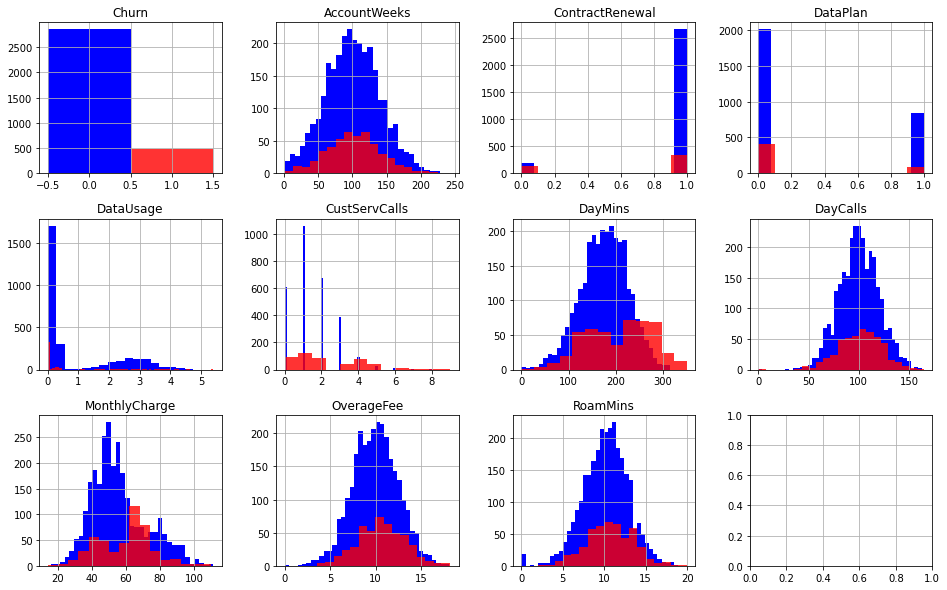

In [115]:
# Create histograms for feature columns separated by prediction label value
register_matplotlib_converters()
nrows = 3; ncols = int(round(train_df.shape[1] / nrows, 0))
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=False, figsize=(16, 10))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
columns = train_df.columns
f = 0
features = []
for i in range(nrows):
    for j in range(ncols):
        if f <= train_df.shape[1]-1:
            assetname = columns[f]
            y0 = train_df[train_df['Churn']==0][assetname]
            ax[i, j].hist(y0, color='blue', label=assetname + '-Churn', bins='auto')
            y1 = train_df[train_df['Churn']==1][assetname]
            ax[i, j].hist(y1, color='red', alpha=0.8, label=assetname + '-NoChurn', bins='auto')
            f += 1
            ax[i, j].set_title(assetname)
            features.append(assetname)
            ax[i, j].grid()
plt.grid()                        
plt.show()

# Preprocessing

In [80]:
# Create Training Dataset
x_df = train_df[train_df.columns[train_df.columns.isin(['AccountWeeks', 'ContractRenewal', 'DataPlan','DataUsage', 'CustServCalls', 'DayCalls', 'MonthlyCharge', 'OverageFee', 'RoamMins'])]].copy()
y_df = train_df['Churn'].copy()
print(x_df.head())
print(y_df.head())

# Split the data into x_train and y_train data sets
x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, train_size=0.7, random_state=0)

   AccountWeeks  ContractRenewal  DataPlan  DataUsage  CustServCalls  \
0           128                1         1        2.7              1   
1           107                1         1        3.7              1   
2           137                1         0        0.0              0   
3            84                0         0        0.0              2   
4            75                0         0        0.0              3   

   DayCalls  MonthlyCharge  OverageFee  RoamMins  
0       110           89.0        9.87      10.0  
1       123           82.0        9.78      13.7  
2       114           52.0        6.06      12.2  
3        71           57.0        3.10       6.6  
4       113           41.0        7.42      10.1  
0    0
1    0
2    0
3    0
4    0
Name: Churn, dtype: int64


# Fit a Decision Forest using Grid Search

In [122]:

# Define parameters
max_depth=[2, 4, 8, 16]
n_estimators = [64, 128, 256]
min_samples_split = [5, 20, 30]

param_grid = dict(max_depth=max_depth, n_estimators=n_estimators, min_samples_split=min_samples_split)

# Build the gridsearch
dfrst = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, class_weight='balanced')
grid = GridSearchCV(estimator=dfrst, param_grid=param_grid, cv = 5)
grid_results = grid.fit(x_train, y_train)

# Summarize the results in a readable format
results_df = pd.DataFrame(grid_results.cv_results_)
results_df.sort_values(by=['rank_test_score'], ascending=True, inplace=True)

# Reduce the results to selected columns
results_filtered = results_df[results_df.columns[results_df.columns.isin(['param_max_depth', 'param_min_samples_split', 'param_n_estimators','std_fit_time', 'rank_test_score', 'std_test_score', 'mean_test_score'])]].copy()
results_filtered

Best: [0.87268107 0.87268107 0.87096801 0.87353944 0.87011148 0.87268291
 0.87568169 0.87096801 0.87268291 0.87953883 0.87826047 0.87782669
 0.87782577 0.87525526 0.87525434 0.87953975 0.87182454 0.87225464
 0.9194144  0.92070011 0.92027369 0.89283345 0.89840457 0.8992611
 0.88211118 0.88425803 0.88253853 0.9232743  0.92498828 0.92713237
 0.9009806  0.89969488 0.90183529 0.88339966 0.88511548 0.88425986], using {'max_depth': 16, 'min_samples_split': 5, 'n_estimators': 256}


#  Best Model Insights

([<matplotlib.axis.XTick at 0x280a2120f48>,
 [Text(0.5, 0, 'False'), Text(1.5, 0, 'True')])

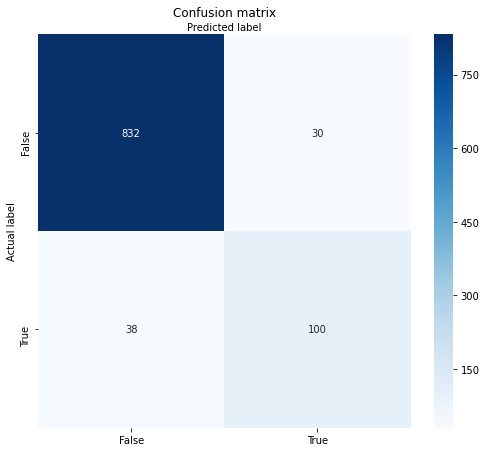

In [101]:
# Extract the best decision forest 
best_clf = grid_results.best_estimator_
y_pred = best_clf.predict(x_test)

# Create a confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Create heatmap from the confusion matrix
class_names=[False, True] 
tick_marks = [0.5, 1.5]
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="Blues", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label'); plt.xlabel('Predicted label')
plt.yticks(tick_marks, class_names); plt.xticks(tick_marks, class_names)

In [127]:
# Predicting Probabilities
y_pred_prob = best_clf.predict_proba(x_test) 
churnproba = y_pred_prob[:,1]


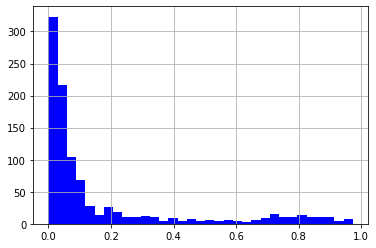

In [131]:
# Create histograms for feature columns separated by prediction label value
register_matplotlib_converters()
plt.hist(churnproba, color='blue', label='Churn', bins='auto')



# nrows = 3; ncols = int(round(train_df.shape[1] / nrows, 0))
# fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=False, figsize=(16, 10))
# fig.subplots_adjust(hspace=0.3, wspace=0.3)
# columns = train_df.columns
# f = 0
# features = []
# for i in range(nrows):
#     for j in range(ncols):
#         if f <= train_df.shape[1]-1:
#             assetname = columns[f]
#             y0 = train_df[train_df['Churn']==0][assetname]
#             ax[i, j].hist(y0, color='blue', label=assetname + '-Churn', bins='auto')
#             y1 = train_df[train_df['Churn']==1][assetname]
#             ax[i, j].hist(y1, color='red', alpha=0.8, label=assetname + '-NoChurn', bins='auto')
#             f += 1
#             ax[i, j].set_title(assetname)
#             features.append(assetname)
#             ax[i, j].grid()
plt.grid()                        
plt.show()

# Best Model Permutation Feature Importance

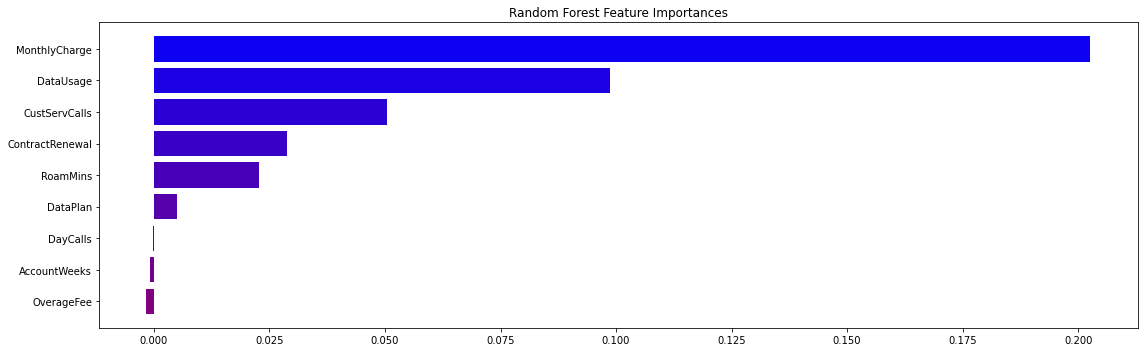

In [102]:
# Load the data
r = permutation_importance(best_clf, x_test, y_test, n_repeats=30, random_state=0)

# Set the color range
clist = [(0, "purple"), (1, "blue")]
rvb = mcolors.LinearSegmentedColormap.from_list("", clist)

# Plot the barchart
x = np.arange(0, len(features))
y = df["Importance"] 
N = y.size
fig, ax = plt.subplots(figsize=(16, 5))
ax.barh(x, y, color=rvb(x/N))
ax.set_yticklabels(df["Feature Names"])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances")
fig.tight_layout()
plt.show()